# CONSTANTS

In [1]:
import math

GLOBAL = {
    'embedded_length': 512,
    'continuity_length': 64,
    'n_vocab': 29
}

# Transformer (Top level)
TRANS_CONST = {
    'n_attention_layers': 8,
    'n_attention_heads': 8,    

    'max_output_length': 6,
    
    'embedding_dic_size': GLOBAL['n_vocab'], 
    'embedded_vec_size': GLOBAL['embedded_length'],
    
    # 'pos_encoding_input': GLOBAL['embedded_length'],
    # 'pos_encoding_output': GLOBAL['embedded_length'],
    
    'linear_input': GLOBAL['embedded_length'],
    'linear_output': GLOBAL['n_vocab'] # output vocab size
}

# Encoder, EncoderLayer
ENCODER_CONST = {
    'norm1_size': GLOBAL['embedded_length'], # same as input matrix width
    'norm2_size': GLOBAL['embedded_length'],

    # maybe rename these two, it's just for knowing the input dim and the dim that the FF layer will work with
    'ff1': GLOBAL['embedded_length'], 
    'ff2': GLOBAL['embedded_length'] * 4
}

# Decoder, DecoderLayer
DECODER_CONST = {
    'norm1_size': GLOBAL['embedded_length'], # same as input matrix width
    'norm2_size': GLOBAL['embedded_length'],
    'norm3_size': GLOBAL['embedded_length'],

    'ff1': GLOBAL['embedded_length'],#TODO RENAME
    'ff2': GLOBAL['embedded_length'] * 4#TODO RENAME
}

# MultiHeadAttention, SingleHeadAttention
ATTENTION_CONST = {
    'mh_concat_width': GLOBAL['continuity_length']*TRANS_CONST['n_attention_heads'], # single head attention width * number of heads
    'mh_output_width': GLOBAL['embedded_length'], #TODO - I'm just guessing this. Didn't see in illustrated transformer. Since we have to use this for the add & norm layer though it has to be the same as the input width (I think)

    # W_q weight matrix 
    'sh_linear1_input': GLOBAL['embedded_length'], # same as embedded length to end up with n_words x 64
    'sh_linear1_output': GLOBAL['continuity_length'], # specified in the paper
    # W_k weight matrix 
    'sh_linear2_input': GLOBAL['embedded_length'], # same as embedded length to end up with n_words x 64
    'sh_linear2_output': GLOBAL['continuity_length'], # specified in the paper
    # W_v weight matrix 
    'sh_linear3_input': GLOBAL['embedded_length'], # same as embedded length to end up with n_words x 64
    'sh_linear3_output': GLOBAL['continuity_length'], # specified in the paper
    
    'sh_scale_factor': math.sqrt(GLOBAL['continuity_length']) # specified in the paper, square root of dimension of key vector/matrix (64)
}

# FeedForward
FEEDFORWARD_CONST = {
    'dropout': 0.1
}



# FEEDFORWARD

In [2]:

import torch.nn as nn

class FeedForward(nn.Module):
    def __init__(self, dim_model, dim_ff, dropout=FEEDFORWARD_CONST['dropout']):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(dim_model, dim_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_ff, dim_model)

    def forward(self, inputs):
        x = inputs
        x = self.linear1(x)
        x = nn.functional.relu(x) 
        x = self.dropout(x) 
        x = self.linear2(x) 
        return x


# MULTIHEADATTENTION

In [3]:

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, masked=False):
        super(MultiHeadAttention, self).__init__()

        self.masked = masked
        self.attentionHeads = nn.ModuleList([SingleHeadAttention(masked) for _ in range(n_heads)])
        self.linear = nn.Linear(ATTENTION_CONST['mh_concat_width'], ATTENTION_CONST['mh_output_width'])
        self.lastHeadKV = None

    def forward(self, inputs, encoderKV=None):
        x = []
        for head in self.attentionHeads:
            sh_attention, k, v = head(inputs, encoderKV=encoderKV) 
            x.append(sh_attention)
        self.lastHeadKV = {'K': k,'V': v}
        x = torch.cat(x, 1) # concatinate all single head attention outputs
        x = self.linear(x) # matmul with weight matrix (linear layer) to get 10x64 shape
        return x

class SingleHeadAttention(nn.Module):
    def __init__(self, masked):
        super(SingleHeadAttention, self).__init__()
        self.masked = masked
        self.linear1 = nn.Linear(ATTENTION_CONST['sh_linear1_input'], ATTENTION_CONST['sh_linear1_output'])
        self.linear2 = nn.Linear(ATTENTION_CONST['sh_linear2_input'], ATTENTION_CONST['sh_linear2_output'])
        self.linear3 = nn.Linear(ATTENTION_CONST['sh_linear3_input'], ATTENTION_CONST['sh_linear3_output'])
        self.scale = nn.Parameter(torch.FloatTensor([ATTENTION_CONST['sh_scale_factor']]))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs, encoderKV=None):        
        q = self.linear1(inputs)
        k = self.linear2(inputs) if encoderKV == None else encoderKV['K']
        v = self.linear3(inputs) if encoderKV == None else encoderKV['V']
        x = torch.matmul(q, k.permute(1, 0)) 
        x = x * self.scale
        # if self.masked:
        #     # TODO "future positions" have to be set to -inf. this is for the decoder to only allow self attention to consider earlier positions.
        x = self.softmax(x) 
        x = torch.matmul(x, v)
        return x if encoderKV != None else x, k, v




# DECODER

In [4]:

import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, n_layers, n_attention_heads):
        super(Decoder, self).__init__()
        
        self.decoderLayers = nn.ModuleList([DecoderLayer(n_attention_heads) for _ in range(n_layers)])

    def forward(self, inputs, encoderKV):
        x = inputs
        for layer in self.decoderLayers:
            x = layer(x, encoderKV) 
        return x

class DecoderLayer(nn.Module):
    def __init__(self, n_attention_heads):
        super(DecoderLayer, self).__init__()

        self.mhattention_masked = MultiHeadAttention(n_attention_heads, masked=True)
        self.mhattention = MultiHeadAttention(n_attention_heads)
        self.feedforward = FeedForward(DECODER_CONST['ff1'], DECODER_CONST['ff2'])
        self.norm1 = nn.LayerNorm(DECODER_CONST['norm1_size'])
        self.norm2 = nn.LayerNorm(DECODER_CONST['norm2_size'])
        self.norm3 = nn.LayerNorm(DECODER_CONST['norm3_size'])

    def forward(self, inputs, encoderKV):
        x = inputs
        z = x
        x = self.mhattention_masked(x) #TODO masking not implemented
        x = z + x
        x = self.norm1(x)
        z = x
        x = self.mhattention(x, encoderKV=encoderKV) 
        x = z + x
        x = self.norm2(x)
        z = x
        x = self.feedforward(x)
        x = z + x
        x = self.norm3(x)
        return x



# ENCODER

In [5]:

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, n_layer, n_attention_heads):
        super(Encoder, self).__init__()
        
        self.encoderLayers = nn.ModuleList([EncoderLayer(n_attention_heads) for _ in range(n_layer)])

    def forward(self, inputs):
        x = inputs
        lastLayerKV = None
        for layer in self.encoderLayers:
            x = layer(x)
            lastLayerKV = layer.lastLayerKV
        return x, lastLayerKV

class EncoderLayer(nn.Module):
    def __init__(self, n_attention_heads):
        super(EncoderLayer, self).__init__()

        self.mhattention = MultiHeadAttention(n_attention_heads)
        self.feedforward = FeedForward(ENCODER_CONST['ff1'], ENCODER_CONST['ff2'])
        self.norm1 = nn.LayerNorm(ENCODER_CONST['norm1_size'])
        self.norm2 = nn.LayerNorm(ENCODER_CONST['norm2_size'])
        self.lastLayerKV = None

    def forward(self, inputs):
        x = inputs 
        z = x
        x = self.mhattention(x)
        self.lastLayerKV = self.mhattention.lastHeadKV
        x = z + x
        x = self.norm1(x)
        z = x
        x = self.feedforward(x)
        x = z + x
        x = self.norm2(x) 
        return x



# TRANSFORMER

In [6]:
import torch
import torch.nn as nn
import numpy

class Transformer(nn.Module):
    def __init__(self, n_layers=TRANS_CONST['n_attention_layers'], n_attention_heads=TRANS_CONST['n_attention_heads']):
        super(Transformer, self).__init__()

        self.encoder = Encoder(n_layers, n_attention_heads)
        self.decoder = Decoder(n_layers, n_attention_heads)
        self.embedding = nn.Embedding(TRANS_CONST['embedding_dic_size'], TRANS_CONST['embedded_vec_size'])
        # self.posEncoding = #TODO
        self.linear = nn.Linear(TRANS_CONST['linear_input'], TRANS_CONST['linear_output'])
        self.softmax = nn.Softmax(dim=1)

    def __call__(self, inputs=None):
        if inputs != None: 
            raise NotImplementedError

        import random
        inputs = []
        for _ in range(13): inputs.append(numpy.zeros(26)) # 26 is vocab size, should be constant; 13 is just a random amount of words in the sequence
        inputs = torch.Tensor(inputs)
        for i in inputs: i[random.randint(0, len(i) - 1)] = 1
        return self.forward(inputs.long())

    def forward(self, inputs):
        # TODO FIRST PRIO
            # get all inputs for embedding (real example for translation tasks etc, noise, decoder input) on the same format, which should be NxV
        #### ENCODING ####
        x = self.doEmbedding(inputs)
        # x = self.posEncoding(x)
        _, encoderKV = self.encoder(x) #TODO try running the encoder output trough 2 additional linear layers to make the KV matrices

        #### DECODING ####
        sos = numpy.zeros(GLOBAL['n_vocab'])
        sos[0] = 1
        x = torch.Tensor([sos])
        ## Embedding
        x = self.doEmbedding(x)
        # x = self.posEncoding(x) #TODO
        ## Decoding
        while len(x) < TRANS_CONST['max_output_length']: #TODO add eos token
            new_word = self.decoder(x, encoderKV)[0, :].unsqueeze(dim=0)
            x = torch.cat([x, new_word], dim=0)

        x = self.linear(x)
        x = self.softmax(x)
        
        return x

    def doEmbedding(self, inputs):
        inputs = inputs.nonzero()[:, 1] # this gets all indices of nonzero values from the inputs matrix
        return self.embedding(inputs)

In [36]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [34]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [26]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
#            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.ntokens.float(), tokens / elapsed))
            start = time.time()
            tokens = 0
    ret = total_loss / total_tokens.float()
    return ret

In [27]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [28]:

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [29]:
import torch.nn as nn

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 1: # Changed > 0 to > 1 because it throws errors otherwise            
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/home/seb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


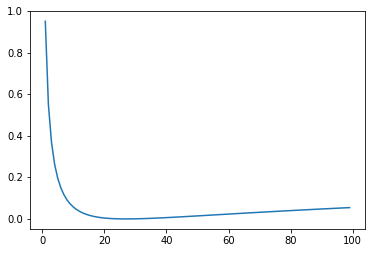

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable


crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

In [31]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))).long()
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [32]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        norm = norm.float() # because it throws errors if it's not casted to float
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        ret = loss.data[0] * norm
        return ret

In [37]:
import time

# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = Transformer() #make_model(V, V, N=2)
model_opt = NoamOpt(512, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model, criterion, model_opt))
    model.eval()

    print('epoch ' + str(epoch + 1))
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

TypeError: forward() takes 2 positional arguments but 5 were given

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
#src = Variable(torch.LongTensor([[1,1, 1, 3, 3, 1, 1, 1, 4, 1]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

# TRAIN

In [21]:
import torch 
import torch.nn as nn
import random
import numpy as np

EPOCHS = 15

transformer = Transformer()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0002)
loss = torch.nn.BCELoss()

real_sample = torch.Tensor([
        [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0]
])
real_sample = torch.Tensor([
        [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
        [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0,0],
])

for _ in range(EPOCHS):
    sample = transformer()        
    # target = torch.ones(sample.shape[0], sample.shape[1])
    error = loss(sample, real_sample)
    if _ % 10 == 0: print(error, sample)
    error.backward()
    optimizer.step()
    if(error > 8): break

tensor(0.1611, grad_fn=<BinaryCrossEntropyBackward>) tensor([[0.0227, 0.0354, 0.0307, 0.0195, 0.0447, 0.0190, 0.0168, 0.0422, 0.0368,
         0.0412, 0.0472, 0.0276, 0.0494, 0.0172, 0.0656, 0.0245, 0.0471, 0.0612,
         0.1000, 0.0223, 0.0625, 0.0138, 0.0224, 0.0245, 0.0512, 0.0087, 0.0151,
         0.0116, 0.0191],
        [0.0273, 0.0292, 0.0275, 0.0187, 0.0638, 0.0339, 0.0151, 0.0375, 0.0474,
         0.0425, 0.0292, 0.0266, 0.0286, 0.0315, 0.0756, 0.0134, 0.0254, 0.0936,
         0.0401, 0.0312, 0.0424, 0.0110, 0.0720, 0.0271, 0.0306, 0.0132, 0.0266,
         0.0211, 0.0179],
        [0.0167, 0.0302, 0.0193, 0.0229, 0.0456, 0.0393, 0.0211, 0.0585, 0.0644,
         0.0513, 0.0276, 0.0237, 0.0396, 0.0219, 0.0500, 0.0136, 0.0350, 0.0972,
         0.0370, 0.0168, 0.0456, 0.0125, 0.0625, 0.0275, 0.0385, 0.0093, 0.0351,
         0.0210, 0.0162],
        [0.0190, 0.0365, 0.0231, 0.0178, 0.0376, 0.0247, 0.0168, 0.0360, 0.0493,
         0.0501, 0.0249, 0.0288, 0.0526, 0.0381, 0.0522, 0.

In [22]:
print(torch.argmax(real_sample, dim=1))
print(torch.argmax(sample, dim=1))

tensor([0, 1, 2, 3, 4, 5])
tensor([0, 5, 5, 5, 5, 5])
